Extracción automática de información(ML Componente): LinkScribe utiliza NLP para extraer automáticamente información relevante de los enlaces, incluyendo el título, la descripción y la imagen de vista previa.

Debe haber un modelo entrenado con NLP que use el dataset dado para aprender a clasificar las paginas web por categoria, el modelo aprendera a leer el contenido, identificara las palabras claves y las pasara para predecir la categoria, para aprender se utilizara el dataset

Website Classification
https://www.kaggle.com/datasets/hetulmehta/website-classification/download?datasetVersionNumber=1

Una opcion es usar BERT y hacer fine tuning para el modelo requerido, esto permite usar un modelo que ya tiene un entendimiento del lenguaje natural en ingles y solo hacer un entrenamiento para llegar a la categorizacion de los datos. Nos podemos basar y ajustar para este caso (pasando de clasificacion binaria del ejemplo a multiclase)

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/



BERT es un modelo de NLP desarrollado por Google. Es un modelo pre-entrenado, y sus siglas representan Bidirectional Encoder Representations for Transformers. Usa transformers de forma bidireccional estableciendo relaciones en un texto, entre la posicion y las palabras previas y posteriores. Genera significado basado en el contexto. BERT se entreno usando Wikipedia en Ingles y el Book Corpus. Este gran dataset le permite aprender relaciones de lenguaje entre palabras.

# Carga de librerias

In [ ]:
# Instalacion de la libreria de transformers, arquitectura empleada en el diseno e implementacion de BERT
# Instalacion libreria de transformers de huggingface

!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.0 MB/s eta 0:00:00


In [ ]:
# Importacion de otras librerias

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

# Especificando GPU
device = torch.device("cuda") # *** Ideal usar GPU cuando esta disponible ***

#device = torch.device("cpu") # Usando cpu *** cuando la gpu no esta disponible *** extremadamente lento para entrenar

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import re
import string

# Instalacion de weight and biases

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.0 MB/s eta 0:00:00


In [ ]:
# Logeo weights and biases
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Carga del dataset a usar para el entrenamiento del modelo

Carga del dataset que se usara para hace entrenamiento (o fine tuning) del modelo de clasificacion

In [ ]:
# Montando Google Drive para poder leer el API token de Kaggle

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Cargando el archivo de autenticacion para kaggle

%cp /content/drive/MyDrive/BackupAI_ML/kaggle.json /content  

In [ ]:
# Carga del dataset desde Kaggle

!pip install kaggle # Para instalar kaggle en el entorno
!chmod 600 kaggle.json # Cambia privilegios al archivo, 6 (110) da permisos de lectura y escritura para el usuario
!ls -l kaggle.json # Verificando los permisos asignados
!mkdir ~/.kaggle  # Kaggle espera encontrar el archivo token en una ubicacion particular
!cp kaggle.json ~/.kaggle/
!kaggle datasets download hetulmehta/website-classification
!unzip /content/website-classification.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-rw------- 1 root root 67 Mar 28 15:45 kaggle.json
100% 2.00M/2.00M [00:01<00:00, 2.00MB/s]
100% 2.00M/2.00M [00:01<00:00, 1.75MB/s]
Archive:  /content/website-classification.zip
  inflating: website_classification.csv  


In [ ]:
df = pd.read_csv('/content/website_classification.csv')
df

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult


# Preparacion y preprocesamiento del dataset

Se usara nltk para preparar el dataset para poder alimentar el modelo

In [ ]:
# Conversion de todas las palabras a minusculas (en caso que hayan caracteres en mayusculas)
df['cleaned_website_text']= df['cleaned_website_text'].apply(lambda x:x.lower())

In [ ]:
# Tokenizacion del texto de contenido del website, permite dividir las cadenas en listas de subcadenas, que pueden ser palabras, signos de puntuacion, caracteres especiales, etc.
nltk.download('punkt') # Descargando los tokenizadores
df['tokenized_words'] = df['cleaned_website_text'].apply(lambda x:word_tokenize(x))
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Unnamed: 0,website_url,cleaned_website_text,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [ ]:
# Eliminacion de caracteres especiales
df['tokenized_words'] = df['tokenized_words'].apply(lambda x:[re.sub(f'[{string.punctuation}]+','',i) for i in x if i not in list(string.punctuation)])
df

,Unnamed: 0,website_url,cleaned_website_text,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [ ]:
# Eliminacion de los stop words los stop words son palabras sin significado por si mismas como artículos, pronombres, preposiciones, etc. normalmente se filtran para el procesamiento de datos en lenguaje natural
nltk.download('stopwords') # Descarga de los stopwords
df['tokenized_words'] = df['tokenized_words'].apply(lambda x:[i for i in x if i not in stopwords.words('english')])
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,website_url,cleaned_website_text,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [ ]:
# Lemmatizacion. La lematización es un proceso lingüístico que consiste en, dada una forma flexionada, hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.
nltk.download('wordnet')
wordnetlemmatizer= WordNetLemmatizer()
df['tokenized_words']=df['tokenized_words'].apply(lambda x:[wordnetlemmatizer.lemmatize(i) for i in x])
df

[nltk_data] Downloading package wordnet to /root/nltk_data...


,Unnamed: 0,website_url,cleaned_website_text,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, site, like, use, vacati..."
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, site, like, previou..."
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,"[cheap, flight, search, compare, flight, momon..."
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, woman, porn, mature, granny, sex, ..."
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cam, bdsm, chat, bondage, cam, free, bd..."
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [ ]:
# Dejando el texto contenido del website unicamente y eliminando la columna original
df['tokenized_words']= df['tokenized_words'].apply(lambda x:' '.join(x))
df.drop(['cleaned_website_text'],axis=1,inplace=True)
df

,Unnamed: 0,website_url,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,Travel,official site good hotel accommodation big sav...
1,1,https://travelsites.com/expedia/,Travel,expedia hotel book site like use vacation work...
2,2,https://travelsites.com/tripadvisor/,Travel,tripadvisor hotel book site like previously de...
3,3,https://www.momondo.in/?ispredir=true,Travel,cheap flight search compare flight momondo fin...
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,Travel,bot create free account create free account si...
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,Adult,old nude woman porn mature granny sex horny ol...
1404,1404,http://www.webcamslave.com,Adult,bdsm cam bdsm chat bondage cam free bdsm video...
1405,1405,http://www.buyeuroporn.com/,Adult,porno dvd online european porn dvd cheap adult...
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,Adult,anal dream house anal dream house anal dream h...


In [ ]:
# Presentacion de las etiquetas que corresponden a cada categoria de website
etiquetas=df['Category'].unique()
print(etiquetas)

['Travel' 'Social Networking and Messaging' 'News' 'Streaming Services'
 'Sports' 'Photography' 'Law and Government' 'Health and Fitness' 'Games'
 'E-Commerce' 'Forums' 'Food' 'Education' 'Computers and Technology'
 'Business/Corporate' 'Adult']


In [ ]:
# Agregando codificacion al campo de categorias, usando label encoder de sklearn
le=LabelEncoder()
df['Category']= le.fit_transform(df['Category'])
df

,Unnamed: 0,website_url,Category,tokenized_words
0,0,https://www.booking.com/index.html?aid=1743217,15,official site good hotel accommodation big sav...
1,1,https://travelsites.com/expedia/,15,expedia hotel book site like use vacation work...
2,2,https://travelsites.com/tripadvisor/,15,tripadvisor hotel book site like previously de...
3,3,https://www.momondo.in/?ispredir=true,15,cheap flight search compare flight momondo fin...
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,15,bot create free account create free account si...
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,0,old nude woman porn mature granny sex horny ol...
1404,1404,http://www.webcamslave.com,0,bdsm cam bdsm chat bondage cam free bdsm video...
1405,1405,http://www.buyeuroporn.com/,0,porno dvd online european porn dvd cheap adult...
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,0,anal dream house anal dream house anal dream h...


# Preparacion de los datos de entrenamiento, prueba y validacion

In [ ]:
# Dividiendo el dataset en entrenamiento, prueba y validacion
train_text, temp_text, train_labels, temp_labels = train_test_split(df['tokenized_words'], df['Category'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Category'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Importacion del modelo pre-entrenado y definicion de la nuevas capas para entrenar y clasificar con las categorias de website de interes

In [ ]:
# Importando el modelo BERT base preentrenado
bert = AutoModel.from_pretrained('bert-base-uncased')

# Cargando el tokenizador BERT, el tokenizador BERT asigna a cada palabra un valor entero para identificarla dentro del diccionario, agregando 
# tokens para el inicio 101, el final 102 y pading tokens para completar y eventualmente mantener un tamano de tensor uniforme. Adicionalmente crea una capa de atencion,
# Que permite enviar las palabras que si son palabras validas (tokens validos) al modelo 
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

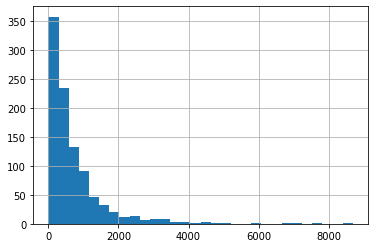

In [ ]:
# Revision del largo de los mensajes dentro del dataset, esto se realiza para optimizar el procesamiento ajustando el tamano de la entrada para que sea representativo
# Sin tener que usar el contenido mas largo
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [38]:
# Inicializacion de weights and biases con los parametros de corrida

wandb.init(
        project="web-cat",
        config={
            "epochs": 100,
            "batch_size": 32,
            "lr": 2e-3,
            "drop_out":0.1
            })

config=wandb.config

In [39]:
# Se observa que hay textos con mas de 8000 palabras pero la gran mayoria tienen 2000 palabras o menos. Intuitivamente se podria usa como dimension 2000 
# Pero el tamano de entrada a BERT es de 512, asi que se usara ese limite como longitud
# *** Un posible refinamiento es tomar todo el texto, y partirlo en bloques de 512, generando mas lineas de entrada al dataset ***

longitud=512 # BERT puede tomar hasta 512

# Se tokenizan y codifican las secuencias en el conjunto de entrenamiento
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),max_length = longitud,pad_to_max_length=True,truncation=True)

# Se tokenizan y codifican las secuencias en el conjunto de validacion
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(),max_length = longitud,pad_to_max_length=True,truncation=True)

# Se tokenizan y codifican las secuencias en el conjunto de prueba
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(),max_length = longitud,pad_to_max_length=True,truncation=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
# Ahora se convierte la secuencia de enteros a tensores

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [41]:
# Creacion de las cargas (batches) para el proceso de entrenamiento y validacion
batch_size = config.batch_size # Tamano del bache, maximo 6 para largo de secuencia de 512
train_data = TensorDataset(train_seq, train_mask, train_y) # Preparacion del tensor de entrenamiento
train_sampler = RandomSampler(train_data) # Muestreo aleatorio para el entrenamiento
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# Cargando los batches para entrenamiento

val_data = TensorDataset(val_seq, val_mask, val_y) # Preparacion del tensor de validacion
val_sampler = SequentialSampler(val_data) # Muestreo secuencial de datos de validacion durante entrenamiento
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size) # Cargando los batches para validacion

In [42]:
# Dejando sin variar los parametros de BERT
for param in bert.parameters():
    param.requires_grad = False

In [43]:
# Definicion de la arquitectura del modelo

class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      self.dropout = nn.Dropout(config.drop_out) # Capa de dropout
      self.relu =  nn.ReLU() # Funcion de activacion relu
      self.fc1 = nn.Linear(768,512) # Primera capa densa fully connected
      self.fc2 = nn.Linear(512,16) # Segunda capa densa, capa de salida. Para este data set se tienen 16 categorias de web sites
      self.softmax = nn.LogSoftmax(dim=1) # Funcion de activacion softmax

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # Pasa las entradas al modelo. Linea modificada
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x

In [44]:
# Pasa el modelo pre-entrenado BERT para definir la arquitectura
model = BERT_Arch(bert)

# Carga el modelo a la GPU
model = model.to(device)

# Se utiliza metodo de gradiente descendente estocastico, con caida de pesos
optimizer = AdamW(model.parameters(),lr = config.lr)          

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
# Calculo del peso de las clases, estos pesos se requiren para evaluar la funcion de perdida ponderadamente
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)
print("Class Weights:",class_weights)

Class Weights: [5.59659091 0.81003289 0.94711538 0.86707746 0.76953125 0.96191406
 5.59659091 0.89221014 0.91884328 1.0434322  0.91884328 0.94711538
 1.06142241 0.84332192 0.83192568 0.82083333]


In [46]:
# Convirtiendo la lista de pesos en tensores 
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device) # Cargando a la GPU
cross_entropy  = nn.NLLLoss(weight=weights) # Definicion de la funcion de perdida

epochs = config.epochs # Numero de epocas de entrenamiento

# Entrenamiento del modelo

In [47]:
# Funcion para el entrenamiento del modelo
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[] # Lista para guardar las predicciones del modelo

  # Iterando sobre los baches
  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0: # Actualizando progreso cada 50 baches
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch] # Bache a la GPU
    sent_id, mask, labels = batch
    model.zero_grad() # Limpia los gradientes calculados        
    preds = model(sent_id, mask) # Obtiene las predicciones del modelo para el bache correspondiente
    loss = cross_entropy(preds, labels) # Calcula la perdida entre los valores actuales y los predichos
    total_loss = total_loss + loss.item() # Calcula la perdida total
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Limita gradientes a 1 para evitar problema de explosion del gradiente
    optimizer.step()
    preds=preds.detach().cpu().numpy() # Predicciones almacenadas en GPU se pasan a CPU
    total_preds.append(preds)

    

  avg_loss = total_loss / len(train_dataloader) # Calcula la perdida para la epoca
  
  total_preds  = np.concatenate(total_preds, axis=0) # Predicciones estan con la forma: numero baches, tamano baches, numero de clases. Reorganiza a numero de muestras, numero de clases

  return avg_loss, total_preds # Retorna la perdida y las predicciones

 

In [48]:
# Funcion para la evaluacion del modelo
def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad(): # Desactiva autograd **??**
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [49]:
# Ejecucion del entrenamiento y validacion. Determinacion y almacenamiento del mejor modelo

# Indica la perdida inicial como infinito
best_valid_loss = float('inf')

# Vacia las listas para almacenar entrenamiento y validacion para cada epoca
train_losses=[]
valid_losses=[]
step=1
# Para cada epoca
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss,__= train() # Ejecuta entrenamiento
    valid_loss,__= evaluate() # Evalua el modelo
    
    # Graba el mejor modelo
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Agrega valores de perdida en entrenamiento y validacion
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Registra las metricas en weight and biases
    metrics = {"Epoch":epoch,"train/train_loss": train_loss, "val_loss": valid_loss}
    wandb.log(metrics)
    step +=1


 Epoch 1 / 100

Evaluating...

Training Loss: 2.889
Validation Loss: 2.756

 Epoch 2 / 100

Evaluating...

Training Loss: 2.753
Validation Loss: 2.738

 Epoch 3 / 100

Evaluating...

Training Loss: 2.695
Validation Loss: 2.727

 Epoch 4 / 100

Evaluating...

Training Loss: 2.622
Validation Loss: 2.627

 Epoch 5 / 100

Evaluating...

Training Loss: 2.564
Validation Loss: 2.563

 Epoch 6 / 100

Evaluating...

Training Loss: 2.452
Validation Loss: 2.521

 Epoch 7 / 100

Evaluating...

Training Loss: 2.406
Validation Loss: 2.344

 Epoch 8 / 100

Evaluating...

Training Loss: 2.311
Validation Loss: 2.271

 Epoch 9 / 100

Evaluating...

Training Loss: 2.190
Validation Loss: 2.205

 Epoch 10 / 100

Evaluating...

Training Loss: 2.119
Validation Loss: 1.999

 Epoch 11 / 100

Evaluating...

Training Loss: 2.010
Validation Loss: 2.013

 Epoch 12 / 100

Evaluating...

Training Loss: 1.928
Validation Loss: 1.889

 Epoch 13 / 100

Evaluating...

Training Loss: 1.882
Validation Loss: 1.846

 Epoch 

In [50]:
# Mejor valor de perdida
print(best_valid_loss)



0.712401922260012


In [51]:
# Carga los pesos del mejor modelo

path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [52]:
# Copia de seguridad de los mejores pesos para uso posterior
import datetime

now = datetime.datetime.now()
date_time_string = now.strftime("%Y_%m_%d_%H%M")

RUN_NAME = f"BERT_epochs{epochs}_batch{batch_size}_run{date_time_string}"

destino='/content/drive/MyDrive/BackupAI_ML/FSAIruns'+'/'+RUN_NAME+'/'

%mkdir {destino}
%cp -R /content/saved_weights.pt {destino}

#**
wandb.log({"best valid loss":best_valid_loss,"Run name":RUN_NAME})

In [53]:
# Realiza predicciones con el subconjunto de prueba
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [54]:
# Reporte de clasificacion

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

wandb.log(classification_report(test_y, preds,output_dict=True))

wandb.finish()

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.79      0.65      0.71        17
           2       0.67      0.86      0.75        14
           3       0.92      0.75      0.83        16
           4       1.00      0.82      0.90        17
           5       0.80      0.86      0.83        14
           6       0.33      0.50      0.40         2
           7       0.82      0.93      0.87        15
           8       0.88      1.00      0.94        15
           9       0.92      0.92      0.92        12
          10       0.88      1.00      0.93        14
          11       0.87      0.93      0.90        14
          12       0.62      0.42      0.50        12
          13       0.84      1.00      0.91        16
          14       0.81      0.81      0.81        16
          15       0.93      0.81      0.87        16

    accuracy                           0.83       212
   macro avg       0.82   

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,▁
best valid loss,▁
train/train_loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▁
Epoch,99
Run name,BERT_epochs100_batch...
accuracy,0.83491
best valid loss,0.7124
train/train_loss,0.69462
val_loss,0.7124


# Prueba del modelo ingresando websites externos

In [ ]:
# Librerias para extraer texto del cuerpo de paginas web

!pip install beautifulsoup4
import urllib.request
from urllib.request import urlopen
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Inicializando una lista para guardar las pruebas

lista_ejemplos=[]

In [ ]:
# Funcion para extraer la fuente html del website

def get_page(url):
    response = urllib.request.urlopen(url)
    soup = BeautifulSoup(response, 
                         'html.parser', 
                         from_encoding=response.info().get_param('charset'))
    return soup # Retorna el string con el html source

In [ ]:
# Funcion para extraer meta data del website 

def get_description(soup):
    if soup.findAll("meta", attrs={"name": "description"}):
        return soup.find("meta", attrs={"name": "description"}).get("content")
    else:
        return

    return # Retorna la meta descripcion del contenido

In [ ]:
# Funcion para extraer el titulo del website

def get_title(soup):
    if soup.findAll("title"):
        return soup.find("title").string
    else:
        return # Retorna el titulo de la pagina

In [ ]:
# Creacion de una funcion que captura una direccion de un website y devuelve los tokens para alimentar al modelo de clasificacion

def web_to_text(url):
  html = urlopen(url).read()
  soup = BeautifulSoup(html, features="html.parser")
  # Elimina todos los elementos de estilo y script
  for script in soup(["script", "style"]):
    script.extract() 
  # Obtiene el texto
  text = soup.body.get_text(separator=' ')
  # Presenta lineas y remueve espacios repetidos al inicio y al final
  lines = (line.strip() for line in text.splitlines())
  # Rompe titulares multiples en una sola linea
  chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
  # Elimina las lineas en blanco
  text = '\n'.join(chunk for chunk in chunks if chunk)
  # Convierte todas las palabras a minusculas
  text=text.lower()
  # Tokenizando el texto, utilizando los tokenizadores de nltk, punkt: Es el tokenizador preentrenado en Ingles
  texto_tokenizado=word_tokenize(text)
  # Eliminacion de los cacteres especiales
  texto_tokenizado=[re.sub(f'[{string.punctuation}]+','',i) for i in texto_tokenizado if i not in list(string.punctuation)]
  # Eliminacion de stopwords, los stop words son palabras sin significado por si mismas como artículos, pronombres, preposiciones, etc. normalmente se filtran para el procesamiento de datos en lenguaje natural
  texto_tokenizado=[i for i in texto_tokenizado if i not in stopwords.words('english')]
  # Lemmatizacion. La lematización es un proceso lingüístico que consiste en, dada una forma flexionada, hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.
  wordnetlemmatizer= WordNetLemmatizer() # Inicializacion del lematizador de nltk
  texto_tokenizado=[wordnetlemmatizer.lemmatize(i) for i in texto_tokenizado]
  # Union de las palabras tokenizadas despues de completar el preprocesamiento
  texto_tokenizado=" ".join(texto_tokenizado)

  return text,texto_tokenizado

In [ ]:
prueba=input("Favor ingrese la direccion del website: ")

texto,texto_tokens=web_to_text(prueba)

print(texto)
print(len(texto))

print(texto_tokens)
print(len(texto_tokens))

lista=[]
lista.append(texto_tokens)

print(lista)

Favor ingrese la direccion del website: https://nordicaphotography.com
nordica photography
main menu stories
blog
nordica
contact
journal
play
film
not just another pretty dress. your wedding is a personal story that we are there to document.
we believe the best results come from telling it like it is. the art happens in recognizing the moments when the setting, subject and mood are in sync and the real story unfolds naturally, without being contrived.
pick a story
danelle & dirk
sirena & eric
erika & romain
paola & andreas
deanna & aaron
sonya & joel
frida & alex
celine & ben
sarah & marc
sylvie & steven
© 2009-2023 nordica photography
cole & jakob   |  email us
join us
608
nordica photography main menu story blog nordica contact journal play film another pretty dress wedding personal story document believe best result come telling like art happens recognizing moment setting subject mood sync real story unfolds naturally without contrived pick story danelle dirk sirena eric erika roma

In [ ]:
sent_id = tokenizer.batch_encode_plus(lista, padding=True)

print(sent_id)

{'input_ids': [[101, 13649, 2050, 5855, 2364, 12183, 2466, 9927, 13649, 2050, 3967, 3485, 2377, 2143, 2178, 3492, 4377, 5030, 3167, 2466, 6254, 2903, 2190, 2765, 2272, 4129, 2066, 2396, 6433, 14622, 2617, 4292, 3395, 6888, 26351, 2613, 2466, 4895, 10371, 2015, 8100, 2302, 9530, 18886, 7178, 4060, 2466, 14569, 6216, 17594, 19558, 2050, 4388, 24900, 12836, 2378, 6643, 6030, 12460, 4670, 2532, 7158, 27926, 8963, 10424, 8524, 4074, 24550, 3841, 4532, 7871, 26009, 7112, 1075, 2268, 11387, 21926, 13649, 2050, 5855, 5624, 19108, 10373, 1057, 3693, 1057, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Tokenizacion al limite de la entrada de Bert: 512 tokens
longitud=512

tokens_prueba = tokenizer.batch_encode_plus(
    lista,
    max_length = longitud,
    pad_to_max_length=True,
    truncation=True
)

print(tokens_prueba)

len(tokens_prueba[0])

{'input_ids': [[101, 13649, 2050, 5855, 2364, 12183, 2466, 9927, 13649, 2050, 3967, 3485, 2377, 2143, 2178, 3492, 4377, 5030, 3167, 2466, 6254, 2903, 2190, 2765, 2272, 4129, 2066, 2396, 6433, 14622, 2617, 4292, 3395, 6888, 26351, 2613, 2466, 4895, 10371, 2015, 8100, 2302, 9530, 18886, 7178, 4060, 2466, 14569, 6216, 17594, 19558, 2050, 4388, 24900, 12836, 2378, 6643, 6030, 12460, 4670, 2532, 7158, 27926, 8963, 10424, 8524, 4074, 24550, 3841, 4532, 7871, 26009, 7112, 1075, 2268, 11387, 21926, 13649, 2050, 5855, 5624, 19108, 10373, 1057, 3693, 1057, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


512

In [ ]:
test_seq = torch.tensor(tokens_prueba['input_ids'])
test_mask = torch.tensor(tokens_prueba['attention_mask'])

In [ ]:
# Prediccion
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

print(preds)
nom_cat=le.inverse_transform([preds[0]])[0]

[11]


In [ ]:
print('La categoria predicha del website:\n',prueba,'\nEs: ',nom_cat)

La categoria predicha del website:
 https://nordicaphotography.com 
Es:  Photography


In [ ]:
# Obtiene el titulo y la descripcion del url

soup=get_page(prueba)
title=get_title(soup)
description=get_description(soup)

In [ ]:
lista_ejemplos.append([prueba,nom_cat,title,description])

In [ ]:
for item in lista_ejemplos:
  print(item)

['https://www.gamesradar.com/retrogamer/ ', 'Games', 'Retro Gamer | GamesRadar+', 'The latest retro game news, reviews and features from the team at Retro Gamer. Subscribe here today.']
['https://www.skype.com/en/', 'Social Networking and Messaging', ' Skype | Stay connected with free video calls worldwide ', 'Keep in touch with free video chat, messaging & affordable international calls. Create instant online video calls with one click, no download required. ']
['https://welcome.miami.edu/academics/index.html ', 'Education', 'Academics | University of Miami', 'As one of the top research universities in the country, the University of Miami brings together esteemed faculty and talented students from throughout the United States and the world. Challenging courses, projects that forge together knowledge and practice, and a stimulating, diverse environment – find it all at the U.']
['https://www.investopedia.com/personal-finance-4427760', 'Education', 'Personal Finance: The Complete Guide'